# suggest_videos

* 歌動画を適当な推薦アルゴリズムを使って推薦します

In [1]:
# Pythonの基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ファイル操作
import os
import glob

# Jupyter上にHTMLを表示する
from IPython.display import HTML

from sklearn.manifold import TSNE

In [66]:
# trainsetから動画を取得する
file_select = 'okakoro'
comments = pd.read_csv('output/train/'+file_select+'/comments.csv', index_col=0)
print("全動画数:", comments.shape[0])
comments.head(3)

全動画数: 17


,Id,Channel,Date,Title,Thumbnail,ViewCount,CommentIds
0,JqwKeddXPOg,Okayu Ch. 猫又おかゆ,2021-07-09T12:00:15Z,p.h. / 猫又おかゆ(cover),https://i.ytimg.com/vi/JqwKeddXPOg/hqdefault.jpg,3597111,"UC1B0CXYaWdjXrPorG3syFlA,UCOwDr6a-HsQxGLIpK1vQ..."
1,G49bAinM6Lc,Korone Ch. 戌神ころね,2020-02-22T12:15:11Z,恋愛裁判 Ver.戌神ころね,https://i.ytimg.com/vi/G49bAinM6Lc/hqdefault.jpg,7745172,"UCesNuEgizYMsZtXVqUH4Btw,UCW_Ck9VtTjZ3b19jSWqW..."
2,4muYzftomAE,Okayu Ch. 猫又おかゆ,2020-08-28T11:00:12Z,flos / 猫又おかゆ (Cover),https://i.ytimg.com/vi/4muYzftomAE/hqdefault.jpg,11707193,"UCI_LsU1fN_B9-04gofaSDLg,UCbGbi2OMR04k1dtqQVGm..."


In [41]:
# コメントしているChannelIdを数値に変換
ids_tmp = []
for i, row in comments.iterrows():    
    comment_ids_string = row['CommentIds']
    comment_ids = comment_ids_string.split(',')
    ids_tmp.append(list(set(comment_ids)))
flatted_ids = [item for l in ids_tmp for item in l] # listの平滑化
# unique_ids = np.array(list(set(unique_ids))) # setを使ってuniqueなものを取り出す
# n = unique_ids.shape[0]
# print(n)

# コメントが2つ以上存在する場合のみ取り出す
sorted_flatted_ids = sorted(flatted_ids)
double = []
ids_prev = ""
for i, ids in enumerate(sorted_flatted_ids):
    if ids_prev == ids:
        double.append(ids)
    ids_prev = ids
unique_ids = np.array(list(set(double))) # setを使ってuniqueなものを取り出す
n = unique_ids.shape[0]
print(n)

5052


In [43]:
# 計算量に無駄が多いので以下などを参考に改良したい
# https://qiita.com/ground0state/items/f516b97c7a8641e474c4
# X = []
# for i, row in comments.iterrows():
#     print(i+1, '/', comments.shape[0])
#     zeros = np.zeros(n)
#     comment_ids_string = row['CommentIds']
#     comment_ids = comment_ids_string.split(',')
#     ids = []
#     for comment_id in comment_ids:
#         ids.append(np.where(unique_ids == comment_id)[0][0])
#     ids = np.array(ids)
#     zeros[ids] = 1
#     X.append(zeros)
# X = np.array(X)

X = []
for i, row in comments.iterrows():
    zeros = np.zeros(n)
    comment_ids_string = row['CommentIds']
    comment_ids = comment_ids_string.split(',')
    ids = []
    for comment_id in comment_ids:
        where = np.where(unique_ids == comment_id)[0]
        if where.size != 0:
            ids.append(where[0])
    ids = np.array(ids)
    zeros[ids] = 1
    X.append(zeros)
X = np.array(X)

In [46]:
comment_ids_modified = []
channels_modified = []

# 二件以上コメントを残していないユーザは削除する
# X_sum = np.sum(X, axis=0)
# useful_ids = np.where(X_sum > 1)[0]
# X_modified = X.T[useful_ids].T

for i, row in comments.iterrows():
    comment_id_modified = np.where(X[i] == 1)[0]
    comment_id_modified = comment_id_modified.astype(str)
    comment_id_modified_string = ','.join(comment_id_modified)
    comment_ids_modified.append(comment_id_modified_string)
comment_ids_modified = np.array(comment_ids_modified)

# channelIDも同様に数値化
unique_channels_tmp = np.array(comments['Channel'])
unique_channels = np.array(list(set(unique_channels_tmp)))
n = unique_channels.shape[0]
    
for i, row in comments.iterrows():
    channel = row['Channel']
    channels_modified.append(np.where(unique_channels == channel)[0][0])
channels_modified = np.array(channels_modified)

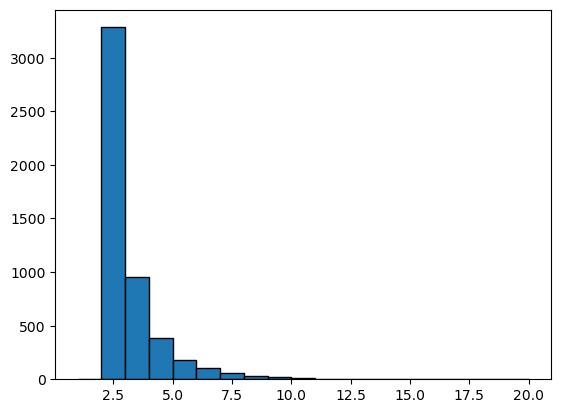

In [47]:
# コメント数の頻度分布を確認する
X_sum = np.sum(X, axis=0)
 
# ヒストグラム
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(X_sum, bins=np.arange(20)+1, histtype='barstacked', ec='black')
plt.show()

In [72]:
# IDを数値に置き換えたものを保存
comments['ChannelModified'] = channels_modified
comments['CommentIdsModified'] = comment_ids_modified
if 'CommentIds' in comments.columns:
    comments = comments.drop(['CommentIds'], axis=1)
comments.to_csv('output/train/'+file_select+'/comments_modified.csv')

In [73]:
# IDを数値に変換したファイルを読み込む
comments = pd.read_csv('output/train/'+file_select+'/comments_modified.csv', index_col=0)
print("全動画数:", comments.shape[0])
comments.head(3)

全動画数: 17


,Id,Channel,Date,Title,Thumbnail,ViewCount,ChannelModified,CommentIdsModified
0,JqwKeddXPOg,Okayu Ch. 猫又おかゆ,2021-07-09T12:00:15Z,p.h. / 猫又おかゆ(cover),https://i.ytimg.com/vi/JqwKeddXPOg/hqdefault.jpg,3597111,1,"7,14,24,25,29,31,35,39,42,58,59,79,80,82,84,10..."
1,G49bAinM6Lc,Korone Ch. 戌神ころね,2020-02-22T12:15:11Z,恋愛裁判 Ver.戌神ころね,https://i.ytimg.com/vi/G49bAinM6Lc/hqdefault.jpg,7745172,0,"4,9,12,30,44,54,63,71,76,82,90,97,113,127,137,..."
2,4muYzftomAE,Okayu Ch. 猫又おかゆ,2020-08-28T11:00:12Z,flos / 猫又おかゆ (Cover),https://i.ytimg.com/vi/4muYzftomAE/hqdefault.jpg,11707193,1,"6,7,23,25,26,28,34,35,36,40,45,46,50,51,57,62,..."


In [75]:
comment_ids_modified = np.array(comments['CommentIdsModified'])
comment_id_max = 0
for i, row in comments.iterrows():
    comment_ids = np.array(comment_ids_modified[i].split(','))
    comment_ids = comment_ids.astype(int)
    if comment_id_max < np.max(comment_ids):
        comment_id_max = np.max(comment_ids)+1

X = np.zeros((comments.shape[0], comment_id_max))
for i, row in comments.iterrows():
    comment_ids = np.array(comment_ids_modified[i].split(','))
    comment_ids = comment_ids.astype(int)
    X[i][comment_ids] = 1

* 適当なアルゴリズムで推薦を行う

In [76]:
def output_html(videos, top_n=10):
    if top_n <= 0:
        top_n = videos.shape[0]
        
    indexes = np.arange(videos.shape[0])[0:top_n]        
    html = '<h1>動画一覧を表示</h1>'
    html += '<div style="float:left;">'
    for i in indexes:
        html += ('<img src="'+np.array(videos['Thumbnail'])[i] +' "alt="取得できませんでした" width="100">')
        # サンプルIDを入れておく
        html += ('<a href="https://www.youtube.com/watch?v='+np.array(videos['Id'])[i]+'">#'+str(i)+'. '+np.array(videos['Title'])[i]+'</a><br>')
    html += '</div>'
    return html

In [80]:
HTML(output_html(comments, top_n=3))

In [88]:
# 自分のお気に入りの動画を指定する（ID指定）
histories = [5, 10]
# 182. 【歌ってみた】グッバイ宣言 / 潤羽るしあ cover
# 219. うっせぇわ／天音かなた＆常闇トワ(Cover)

# historyの動画の一件のコメントした人を取得
titles = np.array(comments['Title'])
channels = np.array(comments['ChannelModified'])

# 推薦動画の取り出し
# 単純に再生数（コメント数）が多い動画が引っかかっている気も？
for history in histories:
    print('閲覧した動画')
    print(titles[history])
    users_id = np.where(X_modified[history]==1)[0]
    users = X_modified.T[users_id]
    users_sum = np.sum(users, axis=0)
    # ランキングする
    ranking = np.argsort(users_sum)[::-1]
    same_channel = 0
    print('オススメの動画')
    for rank in ranking[1:4]:
        if channels[rank] == channels[history]:
            same_channel += 1
        print(rank, titles[rank])
#     print('同じチャンネルの動画数 :', same_channel)
    print('')

閲覧した動画
ふわふわ時間 / 猫又おかゆ (Cover)
オススメの動画
2 flos / 猫又おかゆ (Cover)
7 もぐもぐYUMMY！/ 猫又おかゆ
4 失楽ペトリ / 猫又おかゆ(cover)

閲覧した動画
【original】ころねの最凶天災☆わんだふぉー❤わーるど【戌神ころね/ホロライブ】
オススメの動画
7 もぐもぐYUMMY！/ 猫又おかゆ
16 キャットアイメイク / 猫又おかゆ (Cover)
4 失楽ペトリ / 猫又おかゆ(cover)



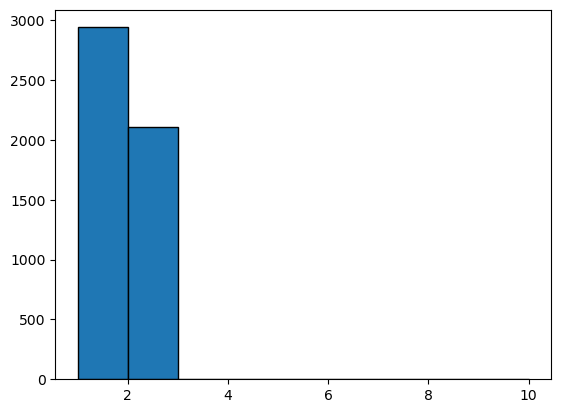

In [89]:
# チャンネルを跨ぐ数を可視化
X_modified2 = np.zeros((32, X_modified.shape[1]))
for i in range(X_modified.shape[0]):
    channel = channels[i]
    X_modified2[channel] += X_modified[i]
X_modified2[X_modified2 > 0] = 1
    
X_sum2 = np.sum(X_modified2, axis=0)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(X_sum2, bins=np.arange(10)+1, histtype='barstacked', ec='black')
plt.show()

In [95]:
def output_html_recommend(videos, indexes):
    html = ''
    html += '<div style="float:left;">'
    # html += 'source: '
    html += ('<img src="'+np.array(videos['Thumbnail'])[indexes[0]] +' "alt="取得できませんでした" width="200">')
    html += ' → '
    for i in indexes[1:]:
        html += ('<img src="'+np.array(videos['Thumbnail'])[i] +' "alt="取得できませんでした" width="200">')
        # html += ('<a href="https://www.youtube.com/watch?v='+np.array(videos['Id'])[i]+'">#'+str(i)+'. '+np.array(videos['Title'])[i]+'</a>')
    html += '</div>'
    return html

recommend_ids = [5, 2, 7]

In [96]:
HTML(output_html_recommend(comments, recommend_ids))

/Users/shinkaitomomichi/opt/anaconda3/envs/study-youtube/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/shinkaitomomichi/opt/anaconda3/envs/study-youtube/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No handles with labels found to put in legend.


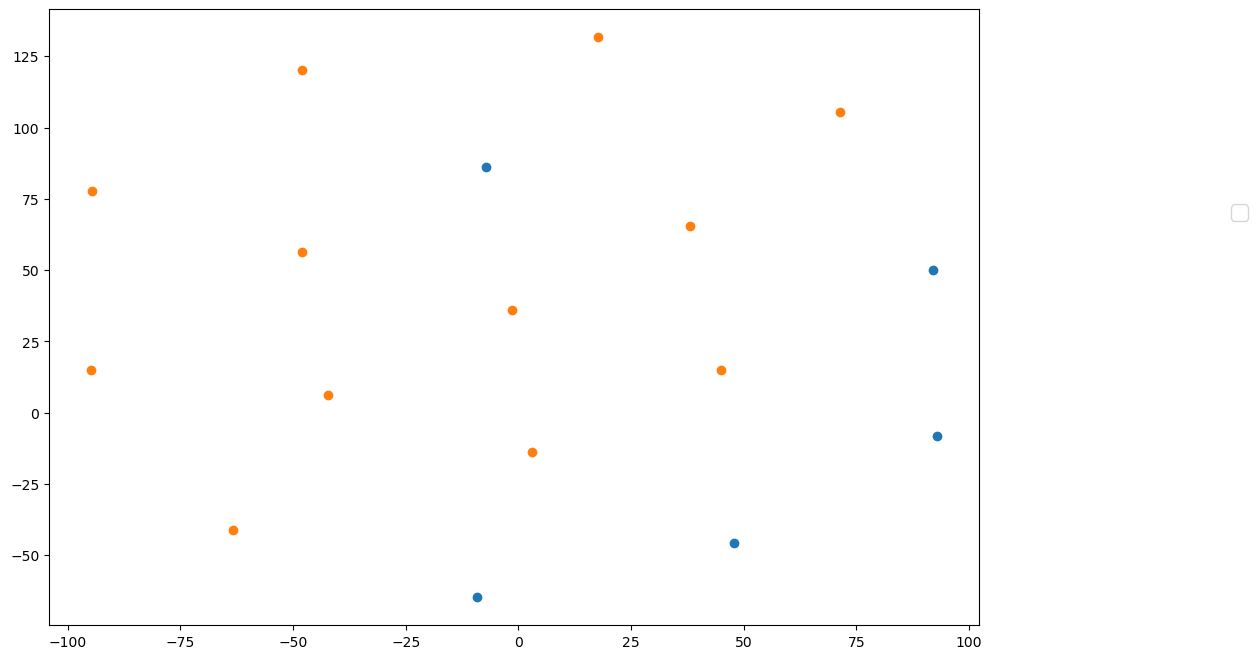

In [99]:
# t-sneでチャンネルごとに可視化
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
X_embedded = tsne.fit_transform(X_modified)

ddf = pd.DataFrame(X_embedded, columns = ['col1', 'col2'])
channels = np.array(comments['ChannelModified'])

scat_x, scat_y = np.array(ddf['col1']), np.array(ddf['col2'])
# channel_names = ['Rushia Uruha', 'Suisei Hoshimachi', 'Aqua Minato', 'Coco Kiryu', 'Hololive Production', 'Mel Yozora', 'Roboco', 'Miko Sakura', 'Fubuki Shirakami', 'Matsuri Natsuiro']
# colors =  ["g", "b", "aqua", "orange", "k", "yellow", "red", "pink", "lightgray", "gold"]
plt.figure(figsize = (12, 8))
for i in range(2):
    # plt.scatter(scat_x[channels==i], scat_y[channels==i], label=channel_names[i], color=colors[i])
    plt.scatter(scat_x[channels==i], scat_y[channels==i])
plt.legend(loc='upper right',
           bbox_to_anchor=(1.3, 0.7, 0, 0), 
           fontsize=15)
plt.show()